<a href="https://colab.research.google.com/github/laks1402/Derma-detection/blob/derma/SkinDiseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [31]:
import pandas as pd
import os

train_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets'

# Initialize lists
train_data = []

# Add image paths and labels to lists
for label, directory in enumerate(os.listdir(train_dir)):
    if directory == '.DS_Store':
        continue

    directory_path = os.path.join(train_dir, directory)
    if not os.path.isdir(directory_path):
        continue

    for filename in os.listdir(directory_path):
        if filename.startswith('.'):
            continue
        image_path = os.path.join(directory_path, filename)
        train_data.append({'image_path': image_path, 'label': label})

train_df = pd.DataFrame(train_data)

df = pd.concat([train_df], ignore_index=True)
del train_data
df.head()


,image_path,label
0,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
1,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
2,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
3,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
4,/content/drive/MyDrive/Colab Notebooks/Dataset...,0


In [25]:

labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
label_map = {i: label for i, label in enumerate(labels)}
num_classes = len(label_map)

print(label_map)


{0: 'Melanoma', 1: 'Vascular Lesions', 2: 'Seborrheic Keratosis', 3: 'Dermatofibroma', 4: 'Basal Cell Carcinoma', 5: 'Acne'}


In [33]:
max_images_per_class = 1500

df = df.sort_values("label").groupby("label").head(max_images_per_class).reset_index(drop=True)

In [34]:
import tensorflow as tf
import multiprocessing

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print(e)

max_workers = multiprocessing.cpu_count()
print(f"Available CPU Cores: {max_workers}")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available CPU Cores: 2


In [35]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
import concurrent.futures
import os
import numpy as np
from PIL import Image

# Resize image arrays
def resize_image_array(image_path):
    try:
        if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp')):
            return np.asarray(Image.open(image_path).resize((128, 128)))
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
    return None

valid_image_paths = [path for path in df['image_path'].tolist() if path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp'))]

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, valid_image_paths))

# Remove failed image
image_arrays = [img for img in image_arrays if img is not None]

# Add the resized image arrays to the DataFrame
df = df[df['image_path'].isin(valid_image_paths)]
df['image'] = image_arrays


In [38]:
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)

total = 0
for class_label, class_name in label_map.items():
    count = class_counts.get(class_label, 0)
    total += count
    print(f"{class_label:<15} {class_name:<30} {count:<10}")

print("-" * 60)
print(f"{'Total':<45} {total:<10}")


Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               Melanoma                       1500      
1               Vascular Lesions               1500      
2               Seborrheic Keratosis           1500      
3               Dermatofibroma                 1500      
4               Basal Cell Carcinoma           1500      
5               Acne                           1500      
------------------------------------------------------------
Total                                         9000      


In [39]:
df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(128, 128, 3)",6245
"(128, 128, 4)",83


In [40]:
# Create an ImageDataGenerator object with the desired transformations
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [41]:
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

for class_label in df['label'].unique():
    image_arrays = df.loc[df['label'] == class_label, 'image'].values

    num_images_needed = max_images_per_class - len(image_arrays)

    augmented_images_list = []
    if num_images_needed > 0:
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

        for image_array in selected_images:
            image_tensor = np.expand_dims(image_array, axis=0)
            augmented_images = train_datagen.flow(image_tensor, batch_size=1)

            for i in range(augmented_images.n):
                augmented_image_array = next(augmented_images)[0].astype('uint8')
                augmented_images_list.append({'image_path': None, 'label': class_label, 'image': augmented_image_array})

    augmented_images_df = pd.DataFrame(augmented_images_list)

    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = pd.concat([augmented_df, original_images_df, augmented_images_df], ignore_index=True)

df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [42]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)

total = 0
for class_label, class_name in label_map.items():
    count = class_counts.get(class_label, 0)  # <-- SAFER
    total += count
    print(f"{class_label:<15} {class_name:<30} {count:<10}")

print("-" * 60)
print(f"{'Total':<45} {total:<10}")


Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               Melanoma                       1500      
1               Vascular Lesions               1500      
2               Seborrheic Keratosis           1500      
3               Dermatofibroma                 1500      
4               Basal Cell Carcinoma           1500      
5               Acne                           1500      
------------------------------------------------------------
Total                                         9000      


In [43]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Function to preprocess images and remove labels of skipped images
def preprocess_images(image_list, label_list, target_size=(128, 128)):
    processed_images = []
    processed_labels = []

    for img, label in zip(image_list, label_list):
        img = np.array(img)

        # Ignore RGBA images (128, 128, 4)
        if img.shape[-1] == 4:
            print("Skipping RGBA image")
            continue

        # Convert grayscale images to RGB
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Resize image to (128, 128)
        img = cv2.resize(img, target_size)

        processed_images.append(img)
        processed_labels.append(label)

    return np.array(processed_images, dtype=np.float32), np.array(processed_labels)

In [44]:
# 80% train + 20% test split
x_train, x_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.20, shuffle=True)

# Convert images into a consistent format, ignoring RGBA images and labels
x_train, y_train = preprocess_images([np.array(img) for img in x_train], y_train)
x_test, y_test = preprocess_images([np.array(img) for img in x_test], y_test)

# Normalize the images
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

num_classes = len(set(df['label']))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Split training data into 60% training + 20% validation
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.25, shuffle=True)

# Ensure correct shape (128, 128, 3)
x_train = x_train.reshape(x_train.shape[0], 128, 128, 3)
x_test = x_test.reshape(x_test.shape[0], 128, 128, 3)
x_validate = x_validate.reshape(x_validate.shape[0], 128, 128, 3)

y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

print("Data preprocessing complete!")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_validate shape: {x_validate.shape}, y_validate shape: {y_validate.shape}")

Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image
Skipping RGBA image


In [45]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [46]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               Melanoma                       895        318          287        1500      
1               Vascular Lesions               916        291          293        1500      
2               Seborrheic Keratosis           860        286          285        1431      
3               Dermatofibroma                 837        306          298        1441      
4               Basal Cell Carcinoma           891        298          311        1500      
5               Acne                           919        274          307        1500      
------------------------------------------------------------------------------------------
Total                                          5318       17

In [47]:
input_shape = df['image'][0].shape

In [48]:
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

input_shape = (128, 128, 3)

# Load ResNet50
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet.trainable = False

# Load MobileNetV2
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
mobilenet.trainable = False

input_layer = Input(shape=input_shape)

# Get feature maps from ResNet50 and MobileNetV2
resnet_features = resnet(input_layer)
mobilenet_features = mobilenet(input_layer)

resnet_flatten = Flatten()(resnet_features)
mobilenet_flatten = Flatten()(mobilenet_features)

# Concatenate features from both models
concatenated = Concatenate()([resnet_flatten, mobilenet_flatten])

x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the hybrid model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

hybrid_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

hybrid_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ input_layer_2[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20480)     │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 53248)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 27,263,488 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │      1,542 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,242,054 (203.10 MB)

 Trainable params: 27,396,358 (104.51 MB)

 Non-trainable params: 25,845,696 (98.59 MB)

In [49]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

class_weights = dict(enumerate(class_weights))

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              factor=0.3,
                              min_lr=1e-5,
                              verbose=1)


In [50]:
# Train the model
history = hybrid_model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_validate, y_validate),
    callbacks=[learning_rate_reduction],
    class_weight=class_weights
)


# Save the hybrid model
hybrid_model.save('/content/drive/MyDrive/Colab Notebooks/Datasets/derma_detect_model.h5')

Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 187ms/step - accuracy: 0.4340 - loss: 1.7342 - precision: 0.4982 - recall: 0.3384 - val_accuracy: 0.7501 - val_loss: 0.7223 - val_precision: 0.8365 - val_recall: 0.6232 - learning_rate: 1.0000e-04
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.6890 - loss: 0.8438 - precision: 0.7694 - recall: 0.6009 - val_accuracy: 0.7992 - val_loss: 0.5876 - val_precision: 0.8629 - val_recall: 0.7276 - learning_rate: 1.0000e-04
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7713 - loss: 0.6557 - precision: 0.8258 - recall: 0.6957 - val_accuracy: 0.8116 - val_loss: 0.5402 - val_precision: 0.8665 - val_recall: 0.7541 - learning_rate: 1.0000e-04
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8105 - loss: 0.5380 - precision: 0.8610 - recall: 0.7586 - val_accuracy: 0.8252 - val_loss: 0.5280 - val_precision: 0.8606 - val_recall: 0.7868 - learning_rate: 1.0000e-04
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 9

In [51]:
# Evaluate the model
loss, accuracy, precision, recall = hybrid_model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Calculate F1-score
y_pred = hybrid_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Test F1-Score: {f1:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.8710 - loss: 0.5254 - precision: 0.8788 - recall: 0.8605
Test Accuracy: 0.8714
Test Precision: 0.8795
Test Recall: 0.8608
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step
Test F1-Score: 0.8699


In [52]:
# Evaluate on training data
train_loss, train_accuracy, train_precision, train_recall = hybrid_model.evaluate(x_train, y_train, verbose=1)
print("\nTraining Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")

# Calculate F1-score for training data
y_train_pred = hybrid_model.predict(x_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
print(f"Train F1-Score: {train_f1:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9999 - loss: 0.0051 - precision: 0.9999 - recall: 0.9999

Training Set Metrics:
Train Accuracy: 0.9998
Train Precision: 0.9998
Train Recall: 0.9998
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
Train F1-Score: 0.9998


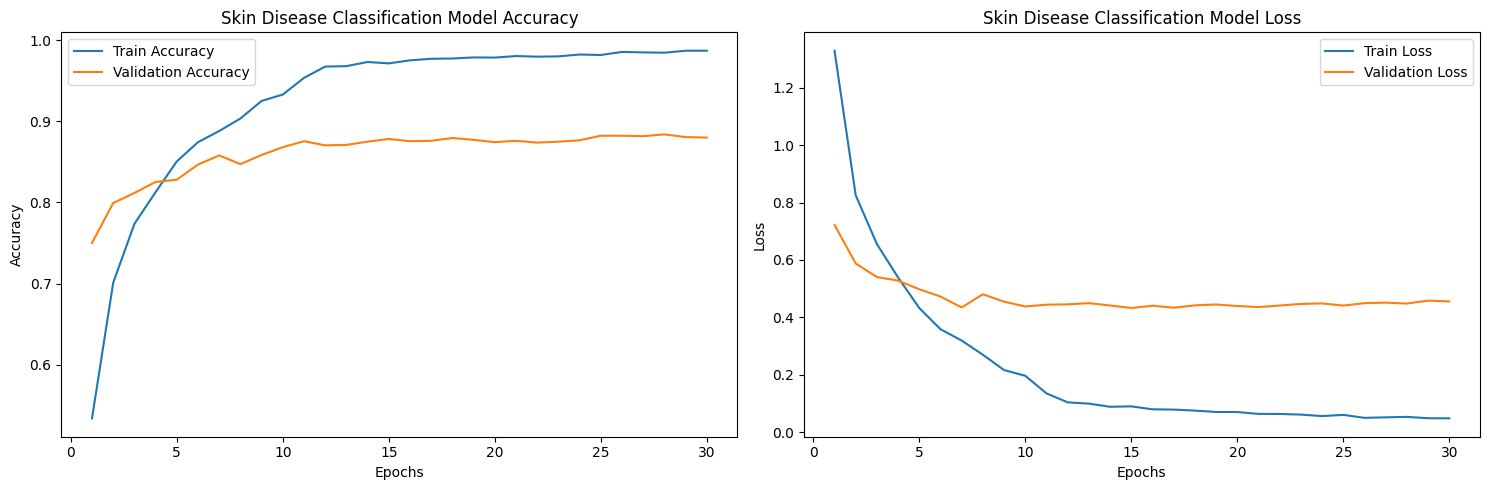

In [53]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Skin Disease Classification Model Accuracy')

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Skin Disease Classification Model Loss')

plt.tight_layout()
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


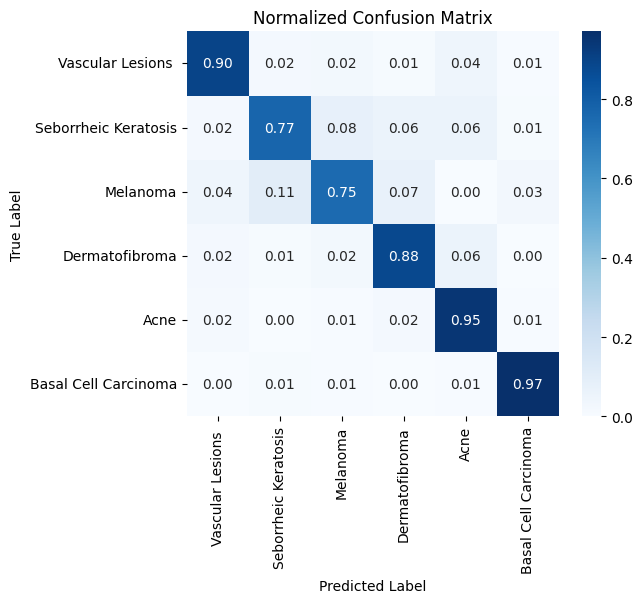

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_prob = hybrid_model.predict(x_test)

y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Vascular Lesions ", "Seborrheic Keratosis", "Melanoma", "Dermatofibroma", "Acne", "Basal Cell Carcinoma"], yticklabels=["Vascular Lesions ", "Seborrheic Keratosis", "Melanoma", "Dermatofibroma", "Acne", "Basal Cell Carcinoma"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


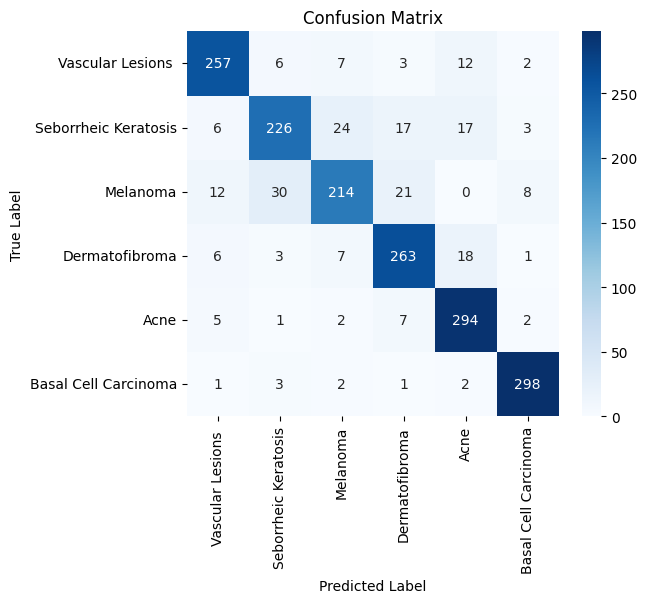

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_prob = hybrid_model.predict(x_test)

y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Vascular Lesions ", "Seborrheic Keratosis", "Melanoma", "Dermatofibroma", "Acne", "Basal Cell Carcinoma"], yticklabels=["Vascular Lesions ", "Seborrheic Keratosis", "Melanoma", "Dermatofibroma", "Acne", "Basal Cell Carcinoma"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


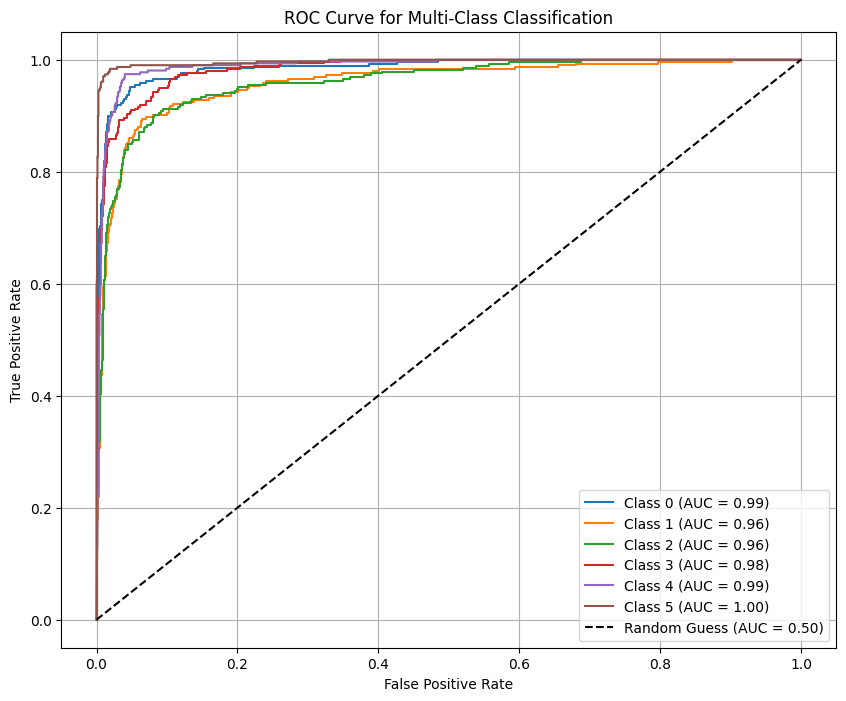

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred_prob = hybrid_model.predict(x_test)

# Number of classes
num_classes = y_test.shape[1]

# ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step

Per-Class Metrics (No Support):
                      precision  recall  f1-score
Melanoma                   0.90    0.90      0.90
Vascular Lesions           0.84    0.77      0.80
Seborrheic Keratosis       0.84    0.75      0.79
Dermatofibroma             0.84    0.88      0.86
Basal Cell Carcinoma       0.86    0.95      0.90
Acne                       0.95    0.97      0.96
accuracy                   0.87    0.87      0.87
macro avg                  0.87    0.87      0.87
weighted avg               0.87    0.87      0.87

Detailed Per-Class Metrics:
                  Class  Precision  Recall  F1-Score
0              Melanoma       0.90    0.90      0.90
1      Vascular Lesions       0.84    0.77      0.80
2  Seborrheic Keratosis       0.84    0.75      0.79
3        Dermatofibroma       0.84    0.88      0.86
4  Basal Cell Carcinoma       0.86    0.95      0.90
5                  Acne       0.95    0.97      0.96


<Figure size 1200x600 with 0 Axes>

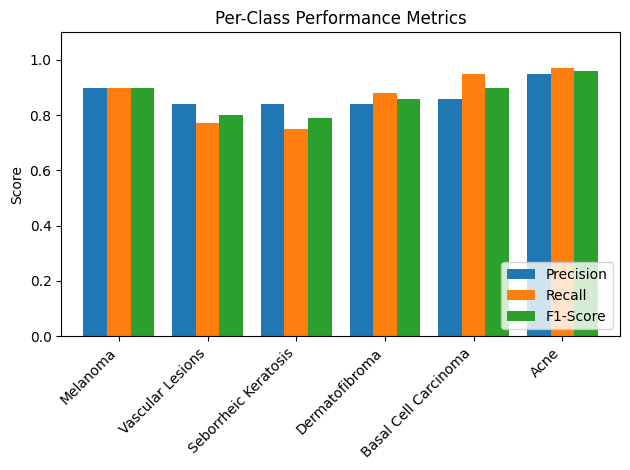

In [57]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
y_pred = hybrid_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(
    y_true_classes, y_pred_classes,
    target_names=label_map.values(),
    output_dict=True
)

# Convert to DataFrame and drop support
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'], errors='ignore')
report_df = report_df.round(2)

print("\nPer-Class Metrics (No Support):")
print(report_df)

# Calculate metrics for each class
precision_per_class = precision_score(y_true_classes, y_pred_classes, average=None)
recall_per_class = recall_score(y_true_classes, y_pred_classes, average=None)
f1_per_class = f1_score(y_true_classes, y_pred_classes, average=None)

# Create a detailed metrics DataFrame (without Support column)
class_metrics = pd.DataFrame({
    'Class': [label_map[i] for i in range(num_classes)],
    'Precision': np.round(precision_per_class, 2),
    'Recall': np.round(recall_per_class, 2),
    'F1-Score': np.round(f1_per_class, 2)
})

print("\nDetailed Per-Class Metrics:")
print(class_metrics)

# Visualize metrics
plt.figure(figsize=(12, 6))
class_metrics[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', width=0.8)
plt.xticks(range(num_classes), class_metrics['Class'], rotation=45, ha='right')
plt.title('Per-Class Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
